# Features extraction from degree>1 and shock propagation through the network

This notebook starts from the output generated at step 4 (04_trades_featureEng.ipynb), enriching the dataset with new features extracted from the network modelled as a bond graph

In [1]:
import numpy as np
import pandas as pd 
from scripts_network.network_analysis_exp import *
from scripts_network.network_bond_graph import *
from scripts_network.network_modelling import *
from scripts_preproc.features_bond_graph_utils import *
import networkx as nx
import seaborn as sns

## Importing data

#### The following process is done step by step for the impairment case to show the whole workflow. 
#### A specific function has been implemented to compress it, and it will be applied to the other credit events.

In [2]:
datafolder = ".."+"/data/"
filename = "03_instrumentsdf_deg1stats.pkl"

df = pd.read_pickle(datafolder+filename)

## Flow Graph modelling for impairment_1

### Adding effort and flow as instrument features - impairment1

- The effort at each edge is calculated as the sum of purchase amounts between a given buyer and a given seller.  
- The flow at each edge is calculated as the sum of the total impairment between the two companies divided by the sum of the invoice amounts.

In [3]:
edge_effort = df.groupby(['customer_name_1', 'debtor_name_1']).apply(lambda x:np.nansum(x.purchase_amount))
edge_flow = df.groupby(['customer_name_1', 'debtor_name_1']).apply(lambda x:np.nansum(x.total_impairment)/np.nansum(x.invoice_amount))

In [4]:
edge_flow[edge_flow.isnull()]=0

In [5]:
df['imp_edge_eff'] = [edge_effort[(df.loc[i, 'customer_name_1'], df.loc[i, 'debtor_name_1'])] for i in df.index]
df['imp_edge_flow'] = [edge_flow[(df.loc[i, 'customer_name_1'], df.loc[i, 'debtor_name_1'])] for i in df.index]
df['imp_edge_eff'] = df['imp_edge_eff'].replace([np.inf, -np.inf], 0)
df['imp_edge_flow'] = df['imp_edge_flow'].replace([np.inf, -np.inf], 0)

### 1. Undirected

Flows go from buyer to seller. There are parallel edges with opposite directions for hybrid cases.  
The graph will be initially modelled as an undirected graph since some of the networkx functions don't work on directed.

In [6]:
g = nx.Graph() #some networkx functions only work on undirected graphs

for cus in df.customer_name_1.unique():
    for debt in df.loc[df.customer_name_1==cus, 'debtor_name_1'].unique():
        
        df_tmp = df[df.customer_name_1==cus]
        df_tmp2 = df_tmp[df_tmp.debtor_name_1==debt]
        g.add_edge(debt, cus)

### 2. Adding impairment_1 features derived from bond graph formalims

In [7]:
df = build_bgtfeat(df,g)

In [8]:
df.describe()

,invoice_amount,purchase_amount,purchase_amount_open,discharge_amount,document_stack_id,test_characteristic_id,bill_id,purchase_examination,deduction_amount,nrecords,...,c_repaid_r,c_impaired1_r,c_pastdue90_r,c_pastdue180_r,imp_edge_eff,imp_edge_flow,imp_d_node_flow,imp_c_node_eff,imp_node_flow,imp_energy
count,5.982000e+04,5.982000e+04,5.982000e+04,2696.000000,59820.000000,1803.000000,59820.000000,11975.000000,47603.000000,59820.000000,...,5.969200e+04,5.969100e+04,59690.000000,59690.000000,5.982000e+04,59820.000000,59820.000000,5.982000e+04,59820.000000,5.982000e+04
mean,6.840900e+03,5.494234e+03,8.477222e+02,7384.895312,9937.816165,5.013866,37925.601204,25.601754,12.552649,2.531010,...,inf,inf,0.020103,0.010856,5.291119e+05,0.014529,2.347308,1.238718e+09,25.118850,8.159791e+09
std,2.760891e+04,2.603158e+04,1.012066e+04,12381.438747,5677.861583,0.116966,21035.770834,30.181423,412.591017,1.519459,...,NaN,NaN,0.054436,0.035920,8.885848e+05,0.059556,6.260445,1.424855e+09,19.305044,2.003589e+10
min,5.110000e+00,0.000000e+00,0.000000e+00,0.010000,1.000000,5.000000,1.000000,4.000000,0.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,1.519963e+03,4.328875e+02,0.000000e+00,390.912500,5542.000000,5.000000,20607.750000,14.000000,0.000000,2.000000,...,4.556052e-01,0.000000e+00,0.000000,0.000000,3.446470e+04,0.000000,0.000000,2.171897e+08,5.075884,2.287730e+07
50%,2.216450e+03,2.016150e+03,0.000000e+00,2233.450000,9842.000000,5.000000,39460.500000,14.000000,0.000000,2.000000,...,6.812315e-01,3.213958e-03,0.000738,0.000000,1.835365e+05,0.000000,0.000000,3.894150e+08,24.886577,3.284329e+08
75%,4.221188e+03,2.871200e+03,0.000000e+00,7894.417500,14654.000000,5.000000,55796.250000,14.000000,0.000000,3.000000,...,7.870435e-01,7.037102e-03,0.010881,0.004194,6.348421e+05,0.004442,1.074920,2.226492e+09,42.838886,4.057329e+09
max,1.777910e+06,1.777910e+06,1.146584e+06,128552.400000,19868.000000,6.000000,72355.000000,165.000000,33011.650000,143.000000,...,inf,inf,1.000000,0.823529,6.307533e+06,1.000346,36.305373,5.313150e+09,66.306407,9.161020e+10


In [9]:
df.head().transpose()

uid,2744:79/231,2861:79/232,2932:79/233,1472:489/688,2042:512/645
customer_id,2004008,2004008,2004008,2004009,2004009
customer_name_1,Castillo GmbH,Castillo GmbH,Castillo GmbH,Orpheus Wyandotte Supply LLC,Orpheus Wyandotte Supply LLC
debtor_id,79,79,79,489,512
debtor_name_1,Sana Hyannis Sarl,Sana Hyannis Sarl,Sana Hyannis Sarl,Isfahan SA,Aldrich Chloe GmbH
invoice_number,2744,2861,2932,1472,2042
invoice_date,2013-07-23 00:00:00,2013-07-30 00:00:00,2013-08-06 00:00:00,2013-08-13 00:00:00,2013-08-13 00:00:00
due_date,2013-08-02 00:00:00,2013-08-09 00:00:00,2013-08-16 00:00:00,2013-08-23 00:00:00,2013-08-23 00:00:00
invoice_amount,913.7,2233.45,1370.5,9195.1,4594.6
purchase_amount,0,0,0,0,0
purchase_amount_open,0,0,0,0,0


### 3. Isolating graph components

In [10]:
a = nx.connected_components(g)
components = [c for c in sorted(a, key=len, reverse=True)]

### 4. Directed graph

In [11]:
directed_graphs = create_directed_graphs(components, df, 10**6)

In [12]:
#dictionary of independent components
comp_dict = dict(zip(range(len(components)), directed_graphs)) #each component corresponds to a number

In [13]:
capacity_list = []
weight_list = []

for line in nx.generate_edgelist(comp_dict[0]):
    capacity_list.append(int(float(line.split(':')[1].split(',')[0].strip())))
    weight_list.append(int(float(line.split(':')[2].split('}')[0].strip())))


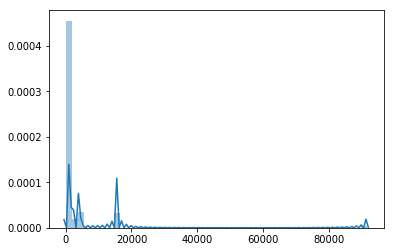

In [14]:
sns.distplot(capacity_list, bins=50)

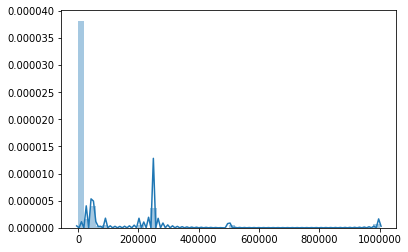

In [15]:
sns.distplot(weight_list, bins=50)

### 5. hybrids and their connections

In [16]:
#the nodes that are both buyers and sellers
customers = df.customer_name_1.unique()
debtors = df.debtor_name_1.unique()
hybrids = [v for v in customers if v in debtors]
hybrids

['Cooperative Inventors Corporation',
 'Remington Muskegon Corporation',
 'McKesson Gumptia Inc.',
 'Telex Inc.',
 'Johansen Wilhelmina Sarl',
 'Alva Apprentices and Pigeonberries SA',
 'Universal Societies Ltd',
 'DARPA Elijah Co.',
 'Katharine Corporation',
 'Tananarive Flintlocks Inc.',
 'Irma SA',
 'Sioux Oslo SA',
 'Rankine Assyria GmbH',
 'Blvd SA',
 'Inman Workbenches and Coquinas Co.']

Hybrids and debtors nodes connected to them are particularly important because they work as capacitors, and as such contribute to the diffusion of a certain credit event in the system creating a chain.  
The debtors directly connected to them can be seen as a starting point of the flow, which will be passed through the capacitors (hybrid nodes) to reach other nodes.
The receiver nodes will be other hybrids or customers (not debtors).  
Nodes wich have the seller role alone are considered as flow sinks (the energy leaves the system through them) or accumulators (without dissipation capability).

In [17]:
# finding the debtor nodes connected to hybrids
connected_to_hyb = [d for d in debtors if len(node_neighborhood(g, d, 1, hybrids))>1]

In [18]:
len(connected_to_hyb)

547

### 6. Flow modelling

In [19]:
#all debtors connected with hybrids with sources of flow >0
df_flow_chain = df[df.debtor_name_1.isin(connected_to_hyb) & df.imp_energy>0] 

In [20]:
conn_to_hyb_sources = df_flow_chain.debtor_name_1.unique() #nodes having flow>0 and connected to hybrids

In [21]:
len(conn_to_hyb_sources)

528

In [22]:
# for each debtor node connected to hybrids, we find the maximum 'chain degree' (the last node reached by the flow of that particular source)
max_degrees = [including_degree(g, nn, hybrids, comp_dict) for nn in conn_to_hyb_sources]

In [23]:
#exlcuding the debtors from the last reached nodes, since only customers can accumulate/dissipate or transmit (if they are hybrids) the flow
max_degrees = pd.Series(max_degrees).apply(lambda x:(x[0], x[1], list(x[2].intersection(set(df.customer_name_1))), x[3]))

In [24]:
#this dictionary will have as keys the starting buyers nodes, as values tuples of (farest flow degree, last hybrid contained in the path, last nodes reached 1 degree after the last hybrids)
dict_start_end = dict(zip(conn_to_hyb_sources, max_degrees))

At this point each "flow path" is detected and the total flow will be computed as a "graph overlapping": for each path a new grah is created, with "sub-flow values" assigned to the respective edges.
In order to obtain the graph containing the total flow, the sum of the subflows is used.

In [25]:
#('Sana Hyannis Sarl', 'Castillo GmbH'), ('Isfahan SA', 'Orpheus Wyandotte Supply LLC'), ('Aldrich Chloe GmbH', 'Orpheus Wyandotte Supply LLC'),
comp_dict[0]['Sana Hyannis Sarl']['Castillo GmbH']

{'capacity': 0, 'weight': 0}

In [26]:
#create flow graphs
graphs = create_flow_graphs(dict_start_end, comp_dict)

2368 graphs successfully created


In [27]:
#identifying graphs with flow>0 and total flow computed
pos_graphs = positive_graphs(graphs)

Total calculated shock flow is 1745779 over 191 graphs with positive flow value


In [23]:
#Total calculated shock flow is 1745835 over 220 graphs with positive flow value

In [28]:
#creating a dictionaries of flow overlaps + check
#it will contain the terminal nodes between edges having positive flow with relative flow value
sum_dict=flow_dict(graphs, pos_graphs)

In [29]:
#for each graph component, the flow is added at each edge as capacity
#all edges flow (addition to the sum_dict of the starting static flows as final overlap)
sum_dict=sum_of_flows(sum_dict, comp_dict)

In [30]:
#assigning the flow value to instruments as a new feature
for edge in sum_dict.keys():
    df.loc[(df.customer_name_1==edge[1]) & (df.debtor_name_1==edge[0]), 'flow_shock_imp1'] = sum_dict[edge]

In [31]:
sum_dict

{('Cooperative Inventors Corporation', 'Genevieve Andrew Limited'): 184,
 ('McKesson Gumptia Inc.', 'Cooperative Inventors Corporation'): 4239,
 ('McKesson Gumptia Inc.', 'Irma SA'): 1446,
 ('Irma SA', 'Genevieve Andrew Limited'): 184,
 ('Northrup Corporation', 'McKesson Gumptia Inc.'): 2032,
 ('McDaniel Ares GmbH', 'McKesson Gumptia Inc.'): 2032,
 ('Irma SA', 'Jove Sequoia Corporation'): 1278,
 ('Kettering Mauritania Co.', 'McKesson Gumptia Inc.'): 2032,
 ('Madras Appraises Co.', 'McKesson Gumptia Inc.'): 2032,
 ('Telex Inc.', 'McKesson Gumptia Inc.'): 2028,
 ('Ophiucus Autocracies SA', 'Telex Inc.'): 78,
 ('Rasmussen Moore Limited', 'McKesson Gumptia Inc.'): 2032,
 ('Ghent Lapelleds Corporation', 'McKesson Gumptia Inc.'): 2032,
 ('Astarte Cadaverouses Inc.', 'McKesson Gumptia Inc.'): 2032,
 ('Ingersoll Spurns Co.', 'McKesson Gumptia Inc.'): 2032,
 ('Antietam Lucres and Disembowels LLC', 'McKesson Gumptia Inc.'): 2032,
 ('Lizzie Rubs and Longs Sarl', 'McKesson Gumptia Inc.'): 2032,
 (

In [30]:
df.head().transpose()

uid,2744:79/231,2861:79/232,2932:79/233,1472:489/688,2042:512/645
customer_id,2004008,2004008,2004008,2004009,2004009
customer_name_1,Castillo GmbH,Castillo GmbH,Castillo GmbH,Orpheus Wyandotte Supply LLC,Orpheus Wyandotte Supply LLC
debtor_id,79,79,79,489,512
debtor_name_1,Sana Hyannis Sarl,Sana Hyannis Sarl,Sana Hyannis Sarl,Isfahan SA,Aldrich Chloe GmbH
invoice_number,2744,2861,2932,1472,2042
invoice_date,2013-07-23 00:00:00,2013-07-30 00:00:00,2013-08-06 00:00:00,2013-08-13 00:00:00,2013-08-13 00:00:00
due_date,2013-08-02 00:00:00,2013-08-09 00:00:00,2013-08-16 00:00:00,2013-08-23 00:00:00,2013-08-23 00:00:00
invoice_amount,913.7,2233.45,1370.5,9195.1,4594.6
purchase_amount,0,0,0,0,0
purchase_amount_open,0,0,0,0,0


#### For the other credit events the process is "compressed" using the custom function add_bg_features 

## Flow graph modelling for pastdue90 (repeating the above process for pastdue_90)

In [4]:
df = add_bg_features(df, 
    col_to_calc_effort = 'payment_date_mismatch',
    effort_col='p90_edge_eff', 
    flow_col='p90_edge_flow', 
    col_to_calc_flow = 'cd_pastdue90_r',
    node_flow_col ='p90_node_flow', 
    energy_col='p90_energy', 
    c_node_eff_col = 'p90_c_node_eff',
    d_node_flow_col = 'p90_d_node_flow', 
    shock_col = 'flow_shock_p90',
    red_coeff=10**4)

Calculating effort and flow...
Creating the undirected graph of the whole dataset network...
Adding effort and flow feature to the dataset...
Isolating components and creating directed graphs...
Looking for hybrid nodes...
Modelling the flow...
Creating flow graphs...
1767 graphs successfully created
Total calculated shock flow is 707134 over 211 graphs with positive flow value
Overlapping the flows...
Adding shock-propagation features...


In [37]:
df.head()

,customer_id,customer_name_1,debtor_id,debtor_name_1,invoice_number,invoice_date,due_date,invoice_amount,purchase_amount,purchase_amount_open,...,imp_node_flow,imp_energy,flow_shock_imp1,p90_edge_eff,p90_edge_flow,p90_d_node_flow,p90_c_node_eff,p90_node_flow,p90_energy,flow_shock_p90
uid,,,,,,,,,,,,,,,,,,,,,
2744:79/231,2004008,Castillo GmbH,79,Sana Hyannis Sarl,2744,2013-07-23,2013-08-02,913.70,0.0,0.0,...,1.770299,15888.322025,1.0,897.0,0.0,0.0,239912.0,0.000000,0.000000,1.0
2861:79/232,2004008,Castillo GmbH,79,Sana Hyannis Sarl,2861,2013-07-30,2013-08-09,2233.45,0.0,0.0,...,1.770299,15888.322025,1.0,897.0,0.0,0.0,239912.0,0.000000,0.000000,1.0
2932:79/233,2004008,Castillo GmbH,79,Sana Hyannis Sarl,2932,2013-08-06,2013-08-16,1370.50,0.0,0.0,...,1.770299,15888.322025,1.0,897.0,0.0,0.0,239912.0,0.000000,0.000000,1.0
1472:489/688,2004009,Orpheus Wyandotte Supply LLC,489,Isfahan SA,1472,2013-08-13,2013-08-23,9195.10,0.0,0.0,...,2.328539,8015.477380,1.0,0.0,0.0,0.0,234247.0,1.665866,366437.206374,36.0
2042:512/645,2004009,Orpheus Wyandotte Supply LLC,512,Aldrich Chloe GmbH,2042,2013-08-13,2013-08-23,4594.60,0.0,0.0,...,2.328539,8015.477380,1.0,1752.0,0.0,0.0,234247.0,1.665866,366437.206374,36.0


## Flow graph modelling for pastdue180

In [3]:
df = add_bg_features(df, 
    col_to_calc_effort = 'payment_date_mismatch',
    effort_col='p180_edge_eff', 
    flow_col='p180_edge_flow', 
    col_to_calc_flow = 'cd_pastdue180_r',
    node_flow_col ='p180_node_flow', 
    energy_col='p180_energy', 
    c_node_eff_col = 'p180_c_node_eff',
    d_node_flow_col = 'p180_d_node_flow', 
    shock_col = 'flow_shock_p180',
    red_coeff=10**5)

Calculating effort and flow...
Creating the undirected graph of the whole dataset network...
Adding effort and flow feature to the dataset...
Isolating components and creating directed graphs...
Looking for hybrid nodes...
Modelling the flow...
Creating flow graphs...
1615 graphs successfully created
Total calculated shock flow is 19893 over 191 graphs with positive flow value
Overlapping the flows...
Adding shock-propagation features...
Done!


In [42]:
df.to_pickle(datafolder+'04_instrumentsdf_bondgraph.pkl')